In [95]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using IntervalArithmetic, IntervalRootFinding
using SharedArrays

using HDF5
using LadderDGA
using Suppressor
using Logging


cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/configs/config_50_100_u1_b12.toml"

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

In [96]:
mP, sP, env, kGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
Î½Grid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Î£_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 38:64 and 38:64 to the same range of 38:64
â”Œ Info: Inputs Read. Starting Computation.
â”‚ Local susceptibilities with ranges are:
â”‚ Ï‡Loc_sp(38:64) = 0.3182, Ï‡Loc_ch(38:64) = 0.1222 
â”” sum Ï‡upup check (fit, tail sub, tail sub + fit, expected): 0.2201987037827738 ?â‰ˆ? 0.22019870378277384 ?=? 0.22019870378277384 ?â‰ˆ? 0.25"


In [97]:
# ladder quantities
bubble = calc_bubble(Î½Grid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_Ï‡_trilex(impQ_sp.Î“, bubble, kG, Î½Grid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_Ï‡_trilex(impQ_ch.Î“, bubble, kG, Î½Grid, sumHelper_f, -mP.U, mP, sP);

# "local" correction quantities
bubbleLoc = calc_bubble(Î½Grid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_Ï‡_trilex(impQ_sp.Î“, bubbleLoc, qGridLoc, Î½Grid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_Ï‡_trilex(impQ_ch.Î“, bubbleLoc, qGridLoc, Î½Grid, sumHelper_f, -mP.U, mP, sP);
Î£_ladderLoc = calc_Î£(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)

Î£_ladderLoc = Î£_ladderLoc .+ mP.n * mP.U/2.0;

nlQ_sp_nÎ» = deepcopy(nlQ_sp);
nlQ_ch_nÎ» = deepcopy(nlQ_ch);

In [98]:
bubbleLoc[1,1,1]

0.004716993502033563 - 0.0im

In [73]:
Î»_sp, Î»_spch  = Î»_correction!(impQ_sp, impQ_ch, FUpDo, Î£_loc, Î£_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

â”Œ Info: Computing Î»sp corrected Ï‡sp, using 
â”‚   sP.Ï‡FillType = lambda_Ï‡_fill::ChiFillType = 1
â””    as fill value outside usable Ï‰ range. = " as fill value outside usable Ï‰ range."
[ Warning: currently using min(usable_sp, usable_ch) = min(34:68,34:68) = 34:68 for all calculations. relax this?
â”Œ Info: Found usable intervals for non-local susceptibility of length 
â”‚ sp: 34:68, length: 35
â”‚ ch: 34:68, length: 35
â”‚ usable: 34:68, length: 35
â”” Ï‡ch sum = 0.16076139077738255, rhs = 0.2796360167881651
â”Œ Info: found 
â”‚   Ï‡_min = -0.08768402270152302
â””   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.08768402270152302, 1.7536804540304605]"
â”Œ Info: Found Î»sp 
â””   Î»sp = 0.608810706895889
[ Info: new lambda correction: Î»sp=0.0 and Î»ch=0.0


(0.608810706895889, [0.0, 0.0])

In [74]:
Î£_ladder = calc_Î£(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Î£_ladder_corrected = Î£_ladder .- Î£_ladderLoc .+ Î£_loc[1:size(Î£_ladder,1)];

# Preparation

For the extended $\lambda$ correction, we need to compute ladder kinetic and potential energy of the system and also compute the DMFT kinetic energy (for improved sums)

In [44]:
# renaming to make code consistent with module
kGrid = kG
iÎ½_array = LadderDGA.iÎ½_array
Î£_internal! = LadderDGA.Î£_internal!
subtract_tail = LadderDGA.subtract_tail
Ï‡_Î»! = LadderDGA.Ï‡_Î»!
kintegrate = LadderDGA.kintegrate
Naive = LadderDGA.Naive

# DMFT Energies
iÎ½â‚™, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
Ïµâ‚–, Vâ‚–, Î¼    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iÎ½â‚™[1:length(GImp)], Ïµâ‚–, Vâ‚–, GImp, mP)



# Ladder Energies
Î£_hartree = mP.n * mP.U/2
E_pot_tail_c = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Î£_hartree .* (kGrid.ÏµkGrid .+ Î£_hartree .- mP.Î¼))
E_pot_tail = E_pot_tail_c' ./ (iÎ½_array(mP.Î², 0:sP.n_iÎ½-1) .^ 2)
E_pot_tail_inv = sum((mP.Î²/2)  .* [Î£_hartree .* ones(size(kGrid.ÏµkGrid)), (-mP.Î²/2) .* E_pot_tail_c]);

In [45]:
function new_Ï‡!(Ï‡_Î»::SharedArray, Ï‡::SharedArray, Î»::Float64)
    for i in eachindex(Ï‡_Î»)
        Ï‡_Î»[i] = 1.0 / ((1.0 / Ï‡[i]) + Î»)
    end
end

Î½Zero = sP.n_iÎ½
Ï‰Zero = sP.n_iÏ‰
Ï‰indices = intersect(nlQ_sp.usable_Ï‰, nlQ_ch.usable_Ï‰)
iÏ‰n = 1im .* 2 .* (-sP.n_iÏ‰:sP.n_iÏ‰)[Ï‰indices] .* Ï€ ./ mP.Î²
sh_f = get_sum_helper(2*sP.n_iÎ½, sP, :f)
sh_b = LadderDGA.Naive() #get_sum_helper(length(Ï‰indices), sP, :b)

Ï‡ch_Ï‰ = kintegrate(kGrid, nlQ_ch.Ï‡[Ï‰indices,:], dim=2)[:,1]
Ï‡ch_Ï‰_sub = subtract_tail(Ï‡ch_Ï‰, impQ_ch.tailCoeffs[3], iÏ‰n)
Ï‡ch_sum = real(sum_freq(Ï‡ch_Ï‰_sub, [1], Naive(), mP.Î², corr=-impQ_ch.tailCoeffs[3]*mP.Î²^2/12)[1])

0.19161700186542138

# Cond 1 Test
## Î»sp(Î»ch)

In [46]:
nh = ceil(Int64, size(nlQ_ch.Ï‡,1)/2)
Î»ch_min = -1 / maximum(real.(nlQ_ch_nÎ».Ï‡[nh,:]))
Î»sp_min = -1 / maximum(real.(nlQ_sp_nÎ».Ï‡[nh,:]))
println("estimated smallest vaue for Î» Î»sp â‰ˆ $(Î»sp_min), Î»ch â‰ˆ $(Î»ch_min)")

estimated smallest vaue for Î» Î»sp â‰ˆ -0.08658444558427382, Î»ch â‰ˆ -2.6221866389083575


In [47]:
Ï‡ch_Î» = Array{Complex{Float64},2}(undef,length(Ï‰indices), size(nlQ_sp.Ï‡,2))
Î»ch_range = Î»ch_min:0.45:10
spOfch_max_nl = zeros(length(Î»ch_range))
Ï‡updo_Ï‰ = Array{eltype(nlQ_sp.Ï‡),1}(undef, length(Ï‰indices))
Ï‡upup_Ï‰ = Array{eltype(nlQ_sp.Ï‡),1}(undef, length(Ï‰indices))

for (Î»i,Î»chi) in enumerate(Î»ch_range)
    Ï‡sp_Î» = real.(deepcopy(nlQ_sp_nÎ».Ï‡[Ï‰indices,:]))
    Ï‡_Î»!(Ï‡ch_Î», nlQ_ch_nÎ».Ï‡[Ï‰indices,:], Î»chi)
    Ï‡ch_Ï‰ = kintegrate(kGrid, Ï‡ch_Î», dim=2)[:,1]
    Ï‡ch_Ï‰_sub = subtract_tail(Ï‡ch_Ï‰, impQ_ch.tailCoeffs[3], iÏ‰n)
    Ï‡ch_sum = real(sum_freq(Ï‡ch_Ï‰_sub, [1], Naive(), mP.Î², corr=-impQ_ch.tailCoeffs[3]*mP.Î²^2/12)[1])
    rhs_val = (mP.n) * (1 - mP.n/2) - Ï‡ch_sum
    spOfch_max_nl[Î»i] = LadderDGA.Î»sp(Ï‡sp_Î», iÏ‰n, E_kin_ED, rhs_val, kGrid, mP)
end

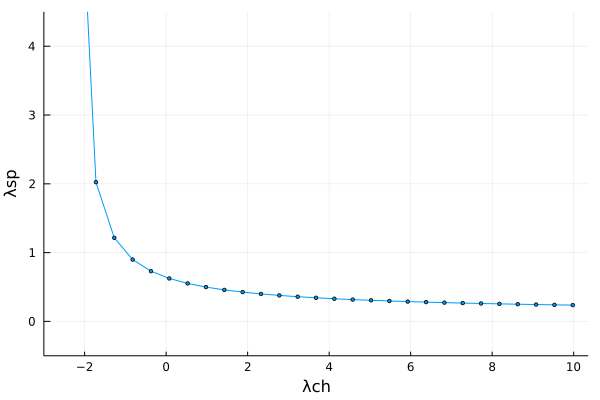

In [48]:
plot(Î»ch_range, spOfch_max_nl, ylims=(-0.5,4.5), markershape=:circle, markersize=2, xlabel="Î»ch", ylabel="Î»sp", label="")

# cond2
## Î»sp(Î»ch)

In [49]:
nh = ceil(Int64, size(nlQ_ch.Ï‡,1)/2)
Î»ch_min = -1 / maximum(real.(nlQ_ch_nÎ».Ï‡[nh,:]))

-2.6221866389083575

In [50]:
using SharedArrays

Ï‡updo_Ï‰ = Array{eltype(nlQ_sp.Ï‡),1}(undef, length(Ï‰indices))
Ï‡upup_Ï‰ = Array{eltype(nlQ_sp.Ï‡),1}(undef, length(Ï‰indices))
res = Array{Float64, 2}(undef, length(Î»ch_range), 6)
nlQ_sp_i = deepcopy(nlQ_sp_nÎ»);
nlQ_ch_i = deepcopy(nlQ_ch_nÎ»);
iÏ‰n = 1im .* 2 .* (-sP.n_iÏ‰:sP.n_iÏ‰)[Ï‰indices] .* Ï€ ./ mP.Î²

for i in 1:length(Î»ch_range)
    print("\r$i of $(length(Î»ch_range))")
    Î»sp_i = spOfch_max_nl[i]
    Î»ch_i = Î»ch_range[i]
    nlQ_sp_i.Ï‡ = LadderDGA.new_Ï‡Î»(nlQ_sp_nÎ».Ï‡, Î»sp_i, sP)
    nlQ_sp_i.Î» = Î»sp_i
    nlQ_ch_i.Ï‡ = LadderDGA.new_Ï‡Î»(nlQ_ch_nÎ».Ï‡, Î»ch_i, sP)
    nlQ_ch_i.Î» = Î»ch_i
    # --> sc
    Î£_ladder_i = calc_Î£(nlQ_sp_i, nlQ_ch_i, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
    Î£_Î» = Î£_ladder_i .- Î£_ladderLoc .+ Î£_loc[1:size(Î£_ladder_i,1)];
    G_Î» = LadderDGA.G_from_Î£(Î£_Î», kGrid.ÏµkGrid, 0:size(Î£_ladder_i, 1)-1, mP)
    # <-- sc
    E_pot_DGA_i = LadderDGA.calc_E_pot(kGrid, LadderDGA.flatten_2D(G_Î»), Î£_Î», view(E_pot_tail,1:size(Î£_ladder_i, 1),:), E_pot_tail_inv)
    for (wi,w) in enumerate(Ï‰indices)
        Ï‡upup_Ï‰[wi] = kintegrate(kGrid, nlQ_ch_i.Ï‡[w,:] .+ nlQ_sp_i.Ï‡[w,:])[1] / 2
        Ï‡updo_Ï‰[wi] = kintegrate(kGrid, nlQ_ch_i.Ï‡[w,:] .- nlQ_sp_i.Ï‡[w,:])[1] / 2
    end
    Ï‡upup_Ï‰ = subtract_tail(Ï‡upup_Ï‰, impQ_ch.tailCoeffs[3], iÏ‰n)
    lhs_c1 = real(sum_freq(Ï‡upup_Ï‰, [1], LadderDGA.Naive(), mP.Î², corr=-impQ_sp.tailCoeffs[3]*mP.Î²^2/12)[1])
    lhs_c2 = real(sum_freq(Ï‡updo_Ï‰, [1], LadderDGA.Naive(), mP.Î²)[1])
    rhs_c1 = mP.n/2 * (1 - mP.n/2)
    rhs_c2 = E_pot_DGA_i/mP.U - (mP.n/2) * (mP.n/2)
    res[i,:] = [Î»sp_i Î»ch_i lhs_c1 rhs_c1 lhs_c2 rhs_c2]
end

29 of 29

In [15]:
E_kin_DGA, E_pot_DGA = LadderDGA.calc_E(Î£_ladder_corrected, kGrid, mP, sP)

LoadError: UndefVarError: Î£_ladder_corrected not defined

In [16]:
G_Î» = LadderDGA.G_from_Î£(Î£_ladder_corrected, kGrid.ÏµkGrid, 0:size(Î£_ladder_corrected, 1)-1, mP)

E_pot_DGA_i = LadderDGA.calc_E_pot_Î½n(kGrid, LadderDGA.flatten_2D(G_Î»), Î£_ladder_corrected, view(E_pot_tail,1:size(Î£_ladder_corrected, 1),:), E_pot_tail_inv)


LoadError: UndefVarError: kGrid not defined

In [17]:
Î£_in = Î£_ladder_corrected .+ mP.n * mP.U/2
E_pot = LadderDGA.flatten_2D(LadderDGA.G_from_Î£(Î£_in, kGrid.ÏµkGrid, 0:73, mP)) .* Î£_in
E_pot_list = [kintegrate(kGrid, 2 .* sum(E_pot[1:i,:], dims=[1])[1,:] .+ E_pot_tail_inv) for i in 1:74]

LoadError: UndefVarError: mP not defined

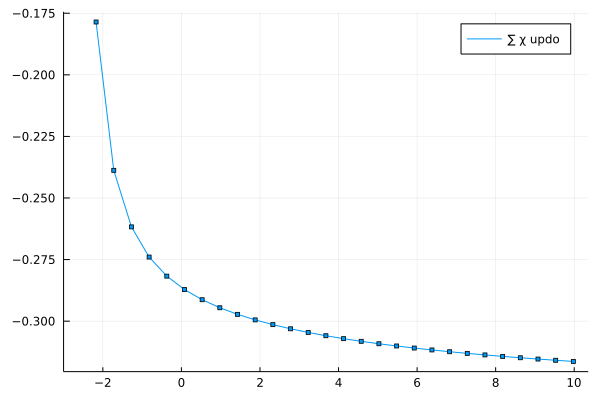

In [57]:
plot(Î»ch_range, res[:,5] .- (res[:,6]./mP.Î²), markershape=:square, markersize=2, label="âˆ‘ Ï‡ updo")
#plot!(Î»ch_range,, markershape=:square, markersize=2, label="G â‹† Î£")
#plot!(Î»ch_range, spOfch_max_nl, ylims=(-5,5), markershape=:circle, markersize=2, xlabel="Î»ch", ylabel="Î»sp", label="")

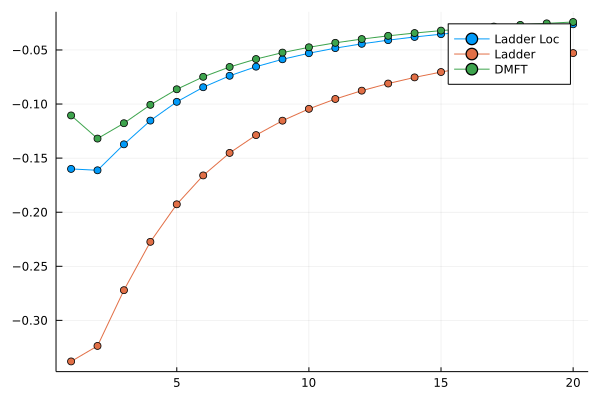

In [81]:
plot(imag(Î£_ladderLoc[1:20]), label="Ladder Loc",markershape=:circle)
plot!(imag(Î£_ladder_corrected[1:20,1]), label="Ladder",markershape=:circle)
plot!(imag(Î£_loc[1:20]), label="DMFT",markershape=:circle)

In [85]:
using JLD2
f = jldopen("/home/julian/Hamburg/lDGA_shift_tests/data/50_100_s1_b12_u1.0/ED_out.jld2")

JLDFile /home/julian/Hamburg/lDGA_shift_tests/data/50_100_s1_b12_u1.0/ED_out.jld2 (read-only)
 â”œâ”€ðŸ”¢ Î“ch
 â”œâ”€ðŸ”¢ Î“sp
 â”œâ”€ðŸ”¢ Ï‡DMFTch
 â”œâ”€ðŸ”¢ Ï‡DMFTsp
 â”œâ”€ðŸ”¢ gImp
 â””â”€ðŸ”¢ g0

In [86]:
f["g0"]

302-element Vector{ComplexF64}:
    0.8656991154798109 - 0.9909405998429446im
   0.40615898770471254 - 0.8045824085301071im
    0.2096225972106768 - 0.612620242205564im
    0.1231571402358523 - 0.4807770785724203im
   0.07975988468917723 - 0.3913542259548549im
   0.05543624698070286 - 0.3283280622823767im
  0.040601619278952325 - 0.28205451081277116im
   0.03094713343816578 - 0.24685327992208636im
   0.02433615018568519 - 0.2192716401304787im
  0.019621579152238985 - 0.19712471163212997im
  0.016146441227305536 - 0.17897534715793748im
  0.013513879829660059 - 0.1638448495109615im
  0.011473282882668231 - 0.15104611727956047im
                       â‹®
 2.1610582034917365e-5 - 0.006574244979659553im
  2.146256953153116e-5 - 0.006551692790506239im
 2.1316072444129563e-5 - 0.0065292947944869725im
 2.1171070156056513e-5 - 0.0065070494156646355im
 2.1027542399957675e-5 - 0.0064849550994880425im
 2.0885469250865864e-5 - 0.006463010312455481im
 2.0744831119256194e-5 - 0.006441213541755484im


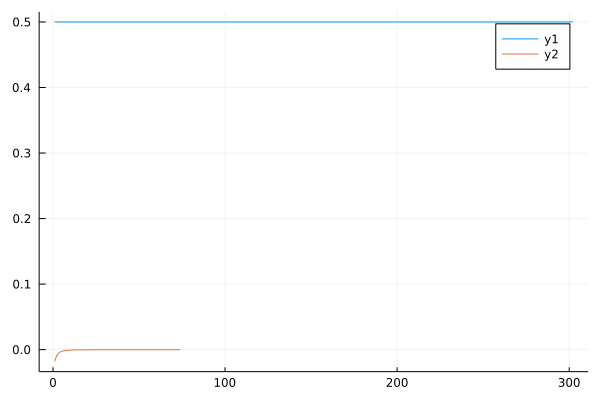

In [76]:
plot(real(Î£_loc))
plot!(real(Î£_ladder_corrected[:,1]))

# extended Lambda test

# Condition 2

In [20]:
println(minimum((lhs_overview .- rhs_overview)))
writedlm("cond2_lhs.csv",  lhs_overview , ' ')
writedlm("cond2_rhs.csv",  rhs_overview , ' ')
plot(heatmap(Î»ch_range_c2, Î»sp_range_c2, (lhs_overview .- rhs_overview), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) -  U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})|"), 
    heatmap(Î»ch_range_c2, Î»sp_range_c2, rhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"U (G^\lambda \star \Sigma^\lambda + \frac{n^2}{4})"), 
    heatmap(Î»ch_range_c2, Î»sp_range_c2, lhs_overview, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(Î»ch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


LoadError: UndefVarError: lhs_overview not defined

In [21]:
println(minimum((lhs_overview2 .+ rhs_overview2)))
writedlm("cond2_lhs2.csv",  lhs_overview2, ' ')
writedlm("cond2_rhs2.csv",  rhs_overview2, ' ')
plot(heatmap(Î»ch_range_c22, Î»sp_range_c22, (lhs_overview2 .- rhs_overview2), xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"|\sum \chi_\mathrm{m}(\omega,q) - G^\lambda \star \Sigma^\lambda|"), 
    heatmap(Î»ch_range_c22, Î»sp_range_c22, rhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"G^\lambda \star \Sigma^\lambda"), 
    heatmap(Î»ch_range_c22, Î»sp_range_c22, lhs_overview2, xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", title=L"\sum \chi_\mathrm{m}(\omega,q)"),
    plot(Î»ch_range[9:end-82], spOfch_max_nl[2,9:end-82], title=L"\sum \chi_\mathrm{d}(\omega, q) \stackrel{!}{=} \frac{n}{2} (1 - \frac{n}{2})", label=L"\lambda_\mathrm{sp}(\lambda_\mathrm{ch})", xlabel=L"\lambda_\mathrm{ch}", ylabel=L"\mathrm{max}(\lambda_\mathrm{sp})", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))


LoadError: UndefVarError: lhs_overview2 not defined

# Both conditions

In [22]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_Ï‰)/2)
Ï‰min = 1
Ï‰max = NW 
coeffs = collect(0:3)
WÏ‰ = LadderDGA.build_weights(Ï‰min, Ï‰max, coeffs)
println("building  weight matrix from $Ï‰min to $Ï‰max with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

testf_c2(Î»spi , Î»chi) = LadderDGA.calc_E_pot_cond(Î»spi , Î»chi, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ÏµkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Î£_loc_pos,Î£_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
function cond_both_nc!(F, Î»)
    testf!(Î») = construct_f(Î»[1],Î»chi, rÏ‡sp, rÏ‡ch, mode=m, rhs=rhs_val)
    testdf!(Î») = construct_df(Î»[1], Î»chi, rÏ‡sp, rÏ‡ch, mode=m, rhs=rhs_val);
    Î£_ladder2, lhs_c2, E_pot_DGA = testf_c2(Î»[1], Î»[2])
    Ï‡sp_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡), Î»[1])
    Ï‡ch_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡), Î»[2])
    Ï‡upup = LadderDGA.sum_q(Ï‡ch_Î»[usable_Ï‰,:].+ Ï‡sp_Î»[usable_Ï‰,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(Ï‡sp_Î»,1)/2)
    penalty = sum(abs.(Ï‡sp_Î»[nwh,(Ï‡sp_Î»[nwh,:] .< 0)])) + sum(abs.(Ï‡ch_Î»[nwh,(Ï‡ch_Î»[nwh,:] .< 0)])) 
    #penalty2 = length(Ï‡ch_Î»[nwh,((Ï‡ch_Î»[nwh,:] .< 0.01) .& (Ï‡ch_Î»[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(Ï‡upup, [1], true, mP.Î², weights=WÏ‰)[1]) 
    #tmp += -penalty
    lhs_c1 = (mP.n/2) * (1 - mP.n/2)
    println("calling for Î»=$Î», E_pot=$(E_pot_DGA), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA# - penalty
end

function cond_both_c!(F, Î»)
    Î£_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(Î»[1], Î»[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ÏµkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Î£_loc_pos,Î£_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    Ï‡sp_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡), Î»[1])
    Ï‡ch_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡), Î»[2])
    Ï‡upup = LadderDGA.sum_q(Ï‡ch_Î»[usable_Ï‰,:].+ Ï‡sp_Î»[usable_Ï‰,:], LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
    nwh = ceil(Int64, size(Ï‡sp_Î»,1)/2)
    penalty = sum(abs.(Ï‡sp_Î»[nwh,(Ï‡sp_Î»[nwh,:] .< 0)])) + sum(abs.(Ï‡ch_Î»[nwh,(Ï‡ch_Î»[nwh,:] .< 0)])) 
    #penalty2 = length(Ï‡ch_Î»[nwh,((Ï‡ch_Î»[nwh,:] .< 0.01) .& (Ï‡ch_Î»[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(Ï‡upup, [1], true, mP.Î², weights=WÏ‰)[1]) 
    #tmp += -penalty
    lhs_c1 = mP.n/2 * (1 - mP.n/2)
    println("calling for Î»=$(round.(Î»,digits=2)), E_pot=$(E_pot_DGA), res = $(abs(tmp - lhs_c1) + abs(E_pot_DGA + (lhs_c2))), penalty = $penalty")
    F[1] = penalty > 0 ? penalty : tmp - lhs_c1
    F[2] = (lhs_c2) - E_pot_DGA
    #F[3] = mP.n - sum(GÎ¼Î»)
end

LoadError: UndefVarError: modelParams not defined

In [23]:
using LaTeXStrings
Ï‡sp_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡[usable_Ï‰,:]), res_nc.zero[1])
Ï‡ch_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡[usable_Ï‰,:]), res_nc.zero[2])
Ï‡upup = LadderDGA.sum_q(Ï‡ch_Î» .+ Ï‡sp_Î», LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
Ï‡updo = LadderDGA.sum_q(Ï‡ch_Î» .- Ï‡sp_Î», LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(Ï‡upup, [1], true, mP.Î², weights=WÏ‰)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(Ï‡updo, [1], true, mP.Î², weights=WÏ‰)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Î£_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ÏµkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Î£_loc_pos,Î£_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Î£_ladder2, LadderDGA.ÏµqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_Ï‰ .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.Î²)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, Ï‡sp_Î»[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, Ï‡sp_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, Ï‡sp_Î»[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(Ï‡sp_Î»[:,1]), maximum(Ï‡sp_Î»[:,nhi]), maximum(Ï‡sp_Î»[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, Ï‡ch_Î»[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, Ï‡ch_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, Ï‡ch_Î»[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(Ï‡ch_Î»[:,1]), maximum(Ï‡ch_Î»[:,nhi]), maximum(Ï‡ch_Î»[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

LoadError: UndefVarError: nlQ_sp not defined

In [24]:
using LaTeXStrings

Ï‡sp_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡[usable_Ï‰,:]), res_nc.zero[1])
Ï‡ch_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡[usable_Ï‰,:]), res_nc.zero[2])
Ï‡sp_Î»_old = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡[usable_Ï‰,:]),0.050817859568877091)
Ï‡ch_Î»_old = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡[usable_Ï‰,:]), 0.0)
Ï‡upup = LadderDGA.sum_q(Ï‡ch_Î» .+ Ï‡sp_Î», LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
Ï‡updo = LadderDGA.sum_q(Ï‡ch_Î» .- Ï‡sp_Î», LadderDGA.qMultiplicity, dims=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(Ï‡upup, [1], true, mP.Î², weights=WÏ‰)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(Ï‡updo, [1], true, mP.Î², weights=WÏ‰)[1])  + mP.n^2/4
lhs_c1 = mP.n/2 * (1 - mP.n/2)
Î£_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ÏµkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Î£_loc_pos,Î£_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Î£_ladder2, LadderDGA.ÏµqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
E_Kin_naive, E_Pot_naive = calc_E_notail(Î£_ladder2, LadderDGA.ÏµqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);
l = @layout [A{0.025h}; 
             grid(1,2)]
nhi = 20
xarr = usable_Ï‰ .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.Î²)", grid = false, showaxis = false, bottom_margin = -50Plots.px, titlefontsize=18)
p1 = plot(xarr, Ï‡sp_Î»_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{sp} = 0.051", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, Ï‡sp_Î»[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", markershape=:hexagon, markerstrokewidth=0.6, markersize=3,
    xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16, margin=4Plots.mm)
#plot!(xarr, Ï‡sp_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
#p1 = plot(xarr, Ï‡sp_Î»[:,end], label=L"q=$(\pi,\pi,\pi)", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(Ï‡sp_Î»[:,1]), maximum(Ï‡sp_Î»[:,nhi]), maximum(Ï‡sp_Î»[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))
    
p2 = plot(xarr, Ï‡ch_Î»_old[:,end], label=L"\mathrm{Old\;Method:}\;\; \lambda_\mathrm{ch} = 0", markershape=:circle, markersize=3, markerstrokewidth=0.6)
plot!(xarr, Ï‡ch_Î»[:,end], color=:orange, legend = :outertop, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label=L"\mathrm{New\;Method:}\; \lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", markershape=:hexagon, markersize=3, markerstrokewidth=0.6,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
#plot!(xarr, Ï‡ch_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
#plot!(xarr, Ï‡ch_Î»[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(Ï‡ch_Î»[:,1]), maximum(Ï‡ch_Î»[:,nhi]), maximum(Ï‡ch_Î»[:,end])])
#annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))
annotate!(xarr[end-2], annotate_y_pos, text(L"\vec{q}=(\pi,\pi,\pi)", :right, 16))



plot(title, p1, p2, layout = l, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: UndefVarError: nlQ_sp not defined

In [25]:
l2 = @layout [A{0.025h}; 
             grid(2,1)]

t = [real(mP.U * real(LadderDGA.sum_freq(Ï‡updo[i+1:(end-i)], [1], true, mP.Î², weights=LadderDGA.build_weights(1, floor(Int64, size(Ï‡upup[i+1:(end-i)], 1)/2), collect(0:3)))[1])  + mP.n^2/4) for i in 8:-1:0]

nanline = repeat([NaN], length(E_Pot))
p3 = plot(E_Pot_naive, xlabel=L"\nu_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\nu,q} G^\lambda \star \Sigma^\lambda\, = %$(round(E_Pot_naive[end], digits=6))",
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright, margin=1Plots.mm,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
#[rhs_c2], seriestype = :hline
plot!(nh-9:nh-1,t,markershape=:hexagon, color=:orange, markersize=4, markerstrokewidth=0.4, label=L"\quad\;\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, do}] = %$(round(rhs_c2, digits=6))")
plot!([rhs_c2], seriestype = :hline, label=nothing, color=:orange)
plot!(nanline, label=" ", alpha= 0.0)
plot!([E_Pot], markershape=:hexagon, markersize=2, markerstrokewidth=0.4, 
    label=L"{\mathrm{SumFit}_{\nu}[G^\lambda \star \Sigma^\lambda]\, = %$(round(E_Pot[end], digits=6))}")

naive_chiupup_sum = (Ï‡upup[nh] .+ 2 .* cumsum(Ï‡upup[nh+1:end])) ./ mP.Î²
tt = [real(LadderDGA.sum_freq(Ï‡upup[i+1:(end-i)], [1], true, mP.Î², weights=LadderDGA.build_weights(1, floor(Int64, size(Ï‡upup[i+1:(end-i)], 1)/2), collect(0:3)))[1]) for i in 8:-1:0]
real(LadderDGA.sum_freq(Ï‡upup, [1], true, mP.Î², weights=WÏ‰)[1]) 

nanline = repeat([NaN], length(tt))
p4 = plot(1:nh-1,naive_chiupup_sum, xlabel=L"\omega_\mathrm{max}", 
    label=L"\;\;\;\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} =   %$(round(naive_chiupup_sum[end],digits=4))", xticks=collect(1:nh-1), margin=5Plots.mm,
    markershape=:hexagon, markersize=2, markerstrokewidth=0.4,legend=:bottomright,xtickfontsize=12,ytickfontsize=12, legendfontsize=12,xguidefontsize=16,yguidefontsize=16)
plot!(nanline, label=" ", alpha= 0.0)
plot!(nh-9:nh-1,tt,markershape=:hexagon, markersize=2, markerstrokewidth=0.4, color=:orange, label=L"\mathrm{SumFit}_{\omega}[\chi_\mathrm{up, up}] = %$(round(rhs_c1,digits=4))")
plot!(nanline, label=" ", alpha= 0.0)

plot!([0.25], seriestype = :hline, color=:green, label=L"\qquad\;\frac{n}{2}\left({1-\frac{n}{2}}\right) = \frac{1}{4}")
annotate_y_pos = (0.08*(maximum(Ï‡upup) - minimum(Ï‡upup)) + minimum(Ï‡upup))
#annotate!(0.3*length(1:nh-1), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=12)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 14))

plot(title, p3, p4, layout = l2, size=(1200,600))
#savefig("cond_solution_tc_test_b25U1_2.pdf")

LoadError: UndefVarError: mP not defined

In [26]:
using LaTeXStrings
usable_Ï‰ = Ï‰indices
lsp_zero = 0.04856121321074435#res_c.zero[1]
lch_zero = 0.1292099471786603#res_c.zero[2]
Ï‡sp_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_sp.Ï‡[usable_Ï‰,:]), lsp_zero)
Ï‡ch_Î» = LadderDGA.Ï‡_Î»(real.(nlQ_ch.Ï‡[usable_Ï‰,:]), lch_zero)
Ï‡upup = LadderDGA.kintegrate(qG, Ï‡ch_Î» .+ Ï‡sp_Î», dim=2)[:,1] ./ 2
Ï‡updo = LadderDGA.kintegrate(qG, Ï‡ch_Î» .- Ï‡sp_Î», dim=2)[:,1] ./ 2
rhs_c1 = real(LadderDGA.sum_freq(Ï‡upup, [1], Naive(), mP.Î²)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(Ï‡updo, [1], Naive(), mP.Î²)[1])  + mP.n^2/4
lhs_c1 = (mP.n/2) * (1 - mP.n/2)
Î£_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(lsp_zero, lch_zero, nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ÏµkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Î£_loc_pos,Î£_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Î£_ladder2, LadderDGA.ÏµqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_Ï‰ .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.Î²), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, Ï‡sp_Î»[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, Ï‡sp_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, Ï‡sp_Î»[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(Ï‡sp_Î»[:,1]), maximum(Ï‡sp_Î»[:,nhi]), maximum(Ï‡sp_Î»[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(lsp_zero,digits=3))", :right, 10))
    
p2 = plot(xarr, Ï‡ch_Î»[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, Ï‡ch_Î»[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, Ï‡ch_Î»[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(Ï‡ch_Î»[:,1]), maximum(Ï‡ch_Î»[:,nhi]), maximum(Ï‡ch_Î»[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(lch_zero,digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
savefig("cond_solution_tc_test_b25U1.pdf")

LoadError: UndefVarError: Ï‰indices not defined

# q-dependent correction

## Fit and subtract old $\frac{1}{i\omega^2}$ tail

In [27]:
using LsqFit
tail_func(iÏ‰n, c)  = sum([c[n] ./ (iÏ‰n .^ (n-1)) for n in 1:length(c)])
tail_func_n0(iÏ‰n, c)  = sum([c[n] ./ (iÏ‰n .^ (n)) for n in 1:length(c)])
tail_func_real(iÏ‰n, c)  = real(sum([c[n] ./ (iÏ‰n .^ (n-1)) for n in 1:length(c)]))
tail_func_real_n0(iÏ‰n, c)  = real(sum([c[n] ./ (iÏ‰n .^ (n)) for n in 1:length(c)]))

tail_func(iÏ‰n, c) = sum([c[n] ./ (iÏ‰n .^ (n-1)) for n in 1:length(c)])
tail_func_r(iÏ‰n, c) = real(sum([c[n] ./ (iÏ‰n .^ (n-1)) for n in 1:length(c)]))
tail_func_0(iÏ‰n, c) = c ./ (iÏ‰n .^ 0)
tail_func_1(iÏ‰n, c) = c ./ (iÏ‰n .^ 1)
tail_func_2(iÏ‰n, c) = real.(c ./ (iÏ‰n .^ 2))

rÏ‡sp = real.(nlQ_sp_nÎ».Ï‡)
rÏ‡ch = real.(nlQ_ch_nÎ».Ï‡)
rÏ‡upup = 0.5 .* real.(rÏ‡sp .+ rÏ‡ch)

nh   = ceil(Int64, size(rÏ‡sp,1)/2) + 20
Ï‰indices_q = nh:last(Ï‰indices)
min_Ï‰ = 1
qind = 1
p2 = [1.0]
p0_2 = [0.0, 0.0, 1.0]
p0_4 = [0.0, 0.0, 1.0, 0.0, 1.0]
p1_2 = [0.0, 1.0]
p1_4 = [0.0, 1.0, 0.0, 1.0]
iÏ‰_arr = LadderDGA.iÏ‰_array(mP.Î², -sP.n_iÏ‰:sP.n_iÏ‰)[Ï‰indices_q];

LoadError: UndefVarError: nlQ_sp_nÎ» not defined

In [28]:
#Tests for setup below

fit_only2 = curve_fit(tail_func_2, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,1], p2)   
fit_0to2 = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,1], p0_2); 
println("Results for fit of Ï‡sp(Ï‰, q=(0,0,0)) fit:")
println("Fit only 2 converged = $(fit_only2.converged) with result $(round.(fit_only2.param,digits=5)).\nFit 0 to 4 converged = $(fit_0to2.converged) with result $(round.(fit_0to2.param,digits=5))")

LoadError: UndefVarError: rÏ‡sp not defined

## Investigation of different tail coefficients

TODO: investigate effect between real part fitting and full fit. For now only real parts are fitted!

In the following we investigate the fitting tails of the form:
 - $\frac{c_2}{i \omega_n^2}$
 - $\sum_{l=0}^2 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=0}^4 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=1}^2 \frac{c_l}{i \omega_n^l}$
 - $\sum_{l=1}^4 \frac{c_l}{i \omega_n^l}$
 
### Plots

The plots show the fit coeffcient $c_2$ for all 5 different methods and for $\chi_\text{sp}$, $\chi_\text{ch}$, $\chi_\text{upup}$. Since the only contribution for the second tail coefficient comes from $\chi_\text{upup}$, all three solutions are supposed to be similar. 

### Remarks: numerics

- When also fitting the $c_4$ coefficient, the tail behavior of $\chi_\text{updo}$ participates and we expect to see a difference between $\chi_\text{sp}$ and $\chi_\text{ch}$. Observing no difference between both suggests insufficient data. 

- A large difference between the $c_2$ and $c\text{0-2}$ fits also suggests faulty input. This is due to the fact, that $c_0$ and $c_1$ must be 0 (since the sum over $\chi_r$ is real and converges)

- The solution will strongly depend on the first bosonic Matsubara frequency used (i.e. if hte fit starts are $i\omega_1$ or $i\omega_{10}$. Setting the `nh` parameter above will generate data for different starting values.

In [29]:
tail_sp = Array{Float64,2}(undef, size(rÏ‡sp,2),5)
tail_ch = Array{Float64,2}(undef, size(rÏ‡sp,2),5)
tail_upup = Array{Float64,2}(undef, size(rÏ‡sp,2),5)

for qi in 1:size(tail_sp,1)
    fit = curve_fit(tail_func_2, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,qi], p2);
    tail_sp[qi,1] = fit.param[1]
    fit = curve_fit(tail_func_2, iÏ‰_arr, rÏ‡ch[Ï‰indices_q,qi], p2);
    tail_ch[qi,1] = fit.param[1]
    fit = curve_fit(tail_func_2, iÏ‰_arr, rÏ‡upup[Ï‰indices_q,qi], p2);
    tail_upup[qi,1] = fit.param[1]
    
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,qi], p0_2);
    tail_sp[qi,2] = fit.param[3]
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡ch[Ï‰indices_q,qi], p0_2);
    tail_ch[qi,2] = fit.param[3]
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡upup[Ï‰indices_q,qi], p0_2);
    tail_upup[qi,2] = fit.param[3]
    
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,qi], p0_4);
    tail_sp[qi,3] = fit.param[3]
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡ch[Ï‰indices_q,qi], p0_4);
    tail_ch[qi,3] = fit.param[3]
    fit = curve_fit(tail_func_real, iÏ‰_arr, rÏ‡upup[Ï‰indices_q,qi], p0_4);
    tail_upup[qi,3] = fit.param[3]
    
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,qi], p1_2);
    tail_sp[qi,4] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡ch[Ï‰indices_q,qi], p1_2);
    tail_ch[qi,4] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡upup[Ï‰indices_q,qi], p1_2);
    tail_upup[qi,4] = fit.param[2]
    
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡sp[Ï‰indices_q,qi], p1_4);
    tail_sp[qi,5] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡ch[Ï‰indices_q,qi], p1_4);
    tail_ch[qi,5] = fit.param[2]
    fit = curve_fit(tail_func_real_n0, iÏ‰_arr, rÏ‡upup[Ï‰indices_q,qi], p1_4);
    tail_upup[qi,5] = fit.param[2]
end

LoadError: UndefVarError: rÏ‡sp not defined

In [30]:
plot(tail_sp[1,:], markershape=:square, markersize=2, label="Ï‡sp", xticks = ([1,2,3,4,5],["c2", "c0-2", "c0-4", "c1-2", "c1-4"]), ylabel=L"c_2(q=(0,0,0))")
plot!(tail_ch[1,:], markershape=:circle, markersize=2, label="Ï‡ch")
plot!(tail_upup[1,:], markershape=:hexagon, markersize=2, label="Ï‡upup")

LoadError: UndefVarError: tail_sp not defined

In [31]:
plot(tail_sp[end,:], markershape=:square, markersize=2, label="Ï‡sp", xticks = ([1,2,3,4,5],["c2", "c0-2", "c0-4", "c1-2", "c1-4"]), ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_ch[end,:], markershape=:circle, markersize=2, label="Ï‡ch")
plot!(tail_upup[end,:], markershape=:hexagon, markersize=2, label="Ï‡upup")

LoadError: UndefVarError: tail_sp not defined

In [32]:
plot(tail_sp[:,1], markershape=:square, markersize=3, label="sp: c2", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,2], markershape=:circle, markersize=3, label="sp: c0-2", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,3], markershape=:hexagon, markersize=3, label="sp: c0-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_sp[:,5], markershape=:diamond, markersize=3, label="sp: c1-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")
plot!(tail_ch[:,5], markershape=:diamond, markersize=3, label="ch: c1-4", ylabel=L"c_2(q=(\pi,\pi\,pi))")

LoadError: UndefVarError: tail_sp not defined

In [33]:
Î£_ladder = calc_Î£(nlQ_sp_nÎ», nlQ_sp_nÎ», bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Î£_ladder_corrected = Î£_ladder .- Î£_ladderLoc .+ Î£_loc[1:size(Î£_ladder,1)]

E_kin_lDGA, E_pot_lDGA = LadderDGA.calc_E(Î£_ladder_corrected, qG, mP, sP);

LoadError: UndefVarError: nlQ_sp_nÎ» not defined